## Using GPU for training

In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla V100-SXM2-16GB


## Installing Hugging Face transformers

In [ ]:
!pip install transformers

     |████████████████████████████████| 1.8MB 8.6MB/s 
     |████████████████████████████████| 2.9MB 57.2MB/s 
     |████████████████████████████████| 890kB 51.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=3dcaf400fac171798987976f0a0bf4421724c17c6358f59cee9c776d26d23d51
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


## Importing packages

In [ ]:
import pandas as pd
import nltk.tokenize.treebank as tb
import re
import torch
import numpy as np
import pickle

#from transformers import AutoTokenizer, AutoModel

## Mounting Drive and Loading Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly&response_type=code

Enter your authorization code:
4/1AY0e-g4JboMQVjf4GDVfcNGSBzFYelSiv33RPRKBEcAUZre69KK5SgQ0H1o


In [ ]:
cd drive/My\ Drive/LAIDEL/  

In [ ]:
data = pd.read_excel ('Data_v1.xlsx')
#data.text=data.text.astype(str)
data.head()

In [ ]:
data.mutation_consequence.value_counts()

## Data Preprocessing

In [ ]:
# Removing nan values
data.dropna(inplace=True)

In [ ]:
data.mutation_consequence.value_counts()

In [ ]:
# Get the lists of sentences and their labels.
sentences = data.text.values
labels = data.mutation_consequence.values

In [ ]:
def remove_text_inside_brackets(text, brackets="()[]{}"):
    count = [0] * (len(brackets) // 2) # count open/close brackets
    saved_chars = []
    for character in text:
        for i, b in enumerate(brackets):
            if character == b: # found bracket
                kind, is_close = divmod(i, 2)
                count[kind] += (-1)**is_close # `+1`: open, `-1`: close
                if count[kind] < 0: # unbalanced bracket
                    count[kind] = 0  # keep it
                else:  # found bracket to remove
                    break
        else: # character is not a [balanced] bracket
            if not any(count): # outside brackets
                saved_chars.append(character)
    return ''.join(saved_chars)


In [ ]:
sample = sentences[10]
sample #before preprocessing

In [ ]:
sample = sample.lower() #converting into lowercase
sample = re.sub(r'[\r\n\n]+', ' ', sample)#removing the new line, carriage return sequences
sample = re.sub(r'[^\x00-\x7F]+', ' ', sample)#removing the special charecters
sample = remove_text_inside_brackets(sample) #removing text inside the braces

sample #after preprocessing

In [ ]:
def preprocessing(sample):

    sample = sample.lower() #converting into lowercase
    sample = re.sub(r'[\r\n\n]+', ' ', sample)#removing the new line, carriage return sequences
    sample = re.sub(r'[^\x00-\x7F]+', ' ', sample)#removing the special charecters
    #sample = remove_text_inside_brackets(sample) #removing text inside the braces

    tokenized = tb.TreebankWordTokenizer().tokenize(sample)
    sentence = ' '.join(tokenized)
    sentence = re.sub(r"\s's\b", "'s", sentence)

    return sentence

In [ ]:
data.text = data.text.apply(lambda x: preprocessing(x))

In [ ]:
# Get the lists of sentences and their labels.
data['mutation_consequence'] = data['mutation_consequence'].astype('category')
# Assigning numerical values and storing in another column
data['labels'] = data['mutation_consequence'].cat.codes

sentences = data.text.values
labels = data.labels.values

## Tokenization & Input Formatting

In [ ]:
from transformers import AutoTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')

tokenizer = AutoTokenizer.from_pretrained("bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12")

In [ ]:
# Print the original sentence.
print(' Original: ', sentences[10])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[10]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[10])))

In [ ]:
# Tokenizing
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
   
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels,dtype=torch.long)


## Training & Validation Split

In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

In [ ]:
# creating data loaders
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 16 #recommended

train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

## Trainig the classification model

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(#'distilbert-base-uncased',
    "bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12", # Use the 12-layer blueBERT model, with an uncased vocab.
    num_labels = 5, 
    output_attentions = False,
    output_hidden_states = False
)

model.cuda()

Some weights of the model checkpoint at bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSeque

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5,  2e-5
                  eps = 2e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 10

total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
import numpy as np

# Function to calculate the accuracy of predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
import random
import numpy as np

# This training code is based on the `run_glue.py`

training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, 30):
    
    # ========================================
    #               Training
    # ========================================
    
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0
    total_train_accuracy = 0

    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
           # print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        # print(b_labels[0])
        
        model.zero_grad()        
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)[:2]
        # print(model(b_input_ids, 
        #                      token_type_ids=None, 
        #                      attention_mask=b_input_mask, 
        #                      labels=b_labels)[:2])

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_train_accuracy += flat_accuracy(logits, label_ids)

        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)  
    avg_train_accuracy = total_train_accuracy / len(train_dataloader)
          
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)
    # ========================================
    #               Validation
    # ========================================
   

    t0 = time.time()

    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)[:2]
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    # print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    # print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    # print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Training Accuracy': avg_train_accuracy,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


Training complete!
Total training took 0:07:16 (h:mm:ss)


In [ ]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Training Accuracy,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,,
1,1.61,0.22,1.59,0.34,0:00:14,0:00:00
2,1.59,0.27,1.57,0.39,0:00:14,0:00:00
3,1.58,0.27,1.48,0.38,0:00:14,0:00:00
4,1.53,0.33,1.60,0.17,0:00:14,0:00:00
5,1.48,0.34,1.49,0.39,0:00:14,0:00:00
6,1.41,0.40,1.80,0.11,0:00:14,0:00:00
7,1.35,0.44,1.74,0.16,0:00:14,0:00:00
8,1.29,0.47,1.44,0.45,0:00:14,0:00:00
9,1.18,0.57,1.37,0.47,0:00:14,0:00:00


In [ ]:
training_stats

[{'Training Accuracy': 0.22098214285714285,
  'Training Loss': 1.6125841055597578,
  'Training Time': '0:00:14',
  'Valid. Accur.': 0.34375,
  'Valid. Loss': 1.5884995460510254,
  'Validation Time': '0:00:00',
  'epoch': 1},
 {'Training Accuracy': 0.265625,
  'Training Loss': 1.5895041355064936,
  'Training Time': '0:00:14',
  'Valid. Accur.': 0.390625,
  'Valid. Loss': 1.5697505474090576,
  'Validation Time': '0:00:00',
  'epoch': 2},
 {'Training Accuracy': 0.27455357142857145,
  'Training Loss': 1.5820957592555456,
  'Training Time': '0:00:14',
  'Valid. Accur.': 0.375,
  'Valid. Loss': 1.4784387648105621,
  'Validation Time': '0:00:00',
  'epoch': 3},
 {'Training Accuracy': 0.3325892857142857,
  'Training Loss': 1.5309639828545707,
  'Training Time': '0:00:14',
  'Valid. Accur.': 0.171875,
  'Valid. Loss': 1.6015504002571106,
  'Validation Time': '0:00:00',
  'epoch': 4},
 {'Training Accuracy': 0.34151785714285715,
  'Training Loss': 1.4804786954607283,
  'Training Time': '0:00:14',

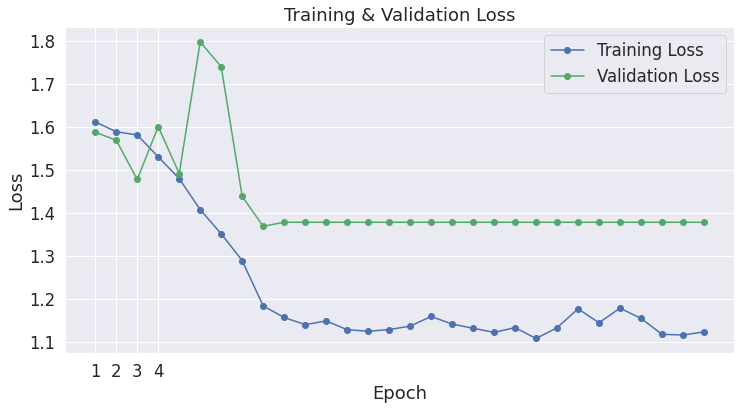

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# # Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training Loss")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation Loss")
# plt.plot(df_stats['Training Accuracy'], 'm-o', label="Training Accuracy")
# plt.plot(df_stats['Valid. Accur.'], 'r-o', label="Validation Accuracy")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

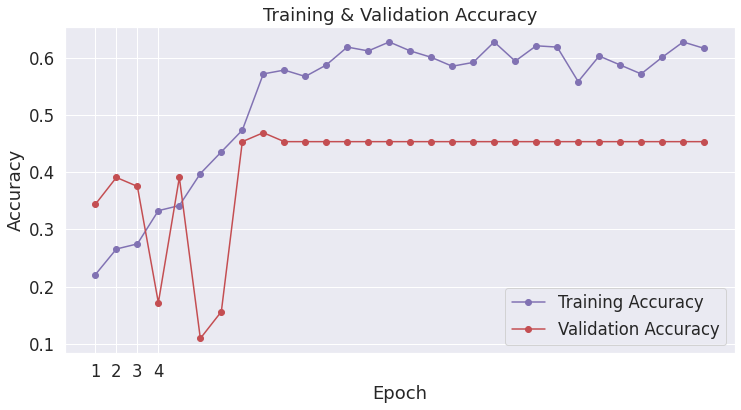

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# # Plot the learning curve.
# plt.plot(df_stats['Training Loss'], 'b-o', label="Training Loss")
# plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation Loss")
plt.plot(df_stats['Training Accuracy'], 'm-o', label="Training Accuracy")
plt.plot(df_stats['Valid. Accur.'], 'r-o', label="Validation Accuracy")

# Label the plot.
plt.title("Training & Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()